# **Anticipez les besoins en consommation de bâtiments** 
## partie 3/3 : Prédire les émissions de Gaz à Effet de Serre

> &emsp; Pour une étude complète, il est possible d'utiliser le notebook 2 : <br><br>
Simplement décommenter la ligne prévue dans la fonction unpack_data() <br>
(première fonction, cellule 1.3) <br><br>
Cela permet de remplacer la cible initiale (conso d'énergie) par les émissions de GES, <br>
pour tout le notebook. <br><br>
Nous allons donc présenter ici une version plus synthétique de la modélisation. <br><br>


### 1 Importation des librairies, réglages

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

import timeit

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, PredictionErrorDisplay
from sklearn.metrics.pairwise import pairwise_distances
# from sklearn.utils import resample

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, BayesianRidge
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

from tensorflow import keras

import scipy
from scipy.sparse import hstack
from scipy import std
from scipy.stats import randint, uniform

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBRegressor

import shap
from lime.lime_tabular import LimeTabularExplainer


pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

sns.set()


### 2 Variables globales

In [133]:
# Initialize an empty list to store model results
model_results = []

targets = ['SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', 
           'TotalGHGEmissions', 'GHGEmissionsIntensity'] # Our targets for this notebook

# for train_test_split
test_size = 0.1

# How many times we test models
nb_iter = 1


### 3 Fonctions

In [134]:
def unpack_data(data, dataset):
    """ 
    Prepares our dataframe for preprocessing
    """
    num = [column for column in data.select_dtypes(include=['number']).columns if column not in targets]
    cat = [column for column in data if column not in (targets + num)]

    X = data.drop(targets, axis=1).copy()
    Y = data[targets].copy()

    # Dans ce notebook, nous allons prédire les émissions de GES
    y_G = Y['TotalGHGEmissions'].copy()
    y_GI = Y['GHGEmissionsIntensity'].copy()

    return (cat, num, X, y_G, y_GI, dataset)

# On les initialize pour simplifier le travail du relecteur syntaxique ^^
cat, num, X, y_G, y_GI, dataset = None, None, None, None, None, None


def preprocessing(y=y_G, alea=42, test_size=test_size, scaler=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=alea)

    numeric_preprocessor = Pipeline(steps=[
        ("scaler", scaler)
        ])
    
    # drop_idx_[0] ?
    categorical_preprocessor = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])
    
    # ascategorical first ? Apparemment pas besoin
    preprocessor = ColumnTransformer([
        ("categorical", categorical_preprocessor, cat),
        ("numerical", numeric_preprocessor, num)],
        verbose_feature_names_out=True,  # prepend the preprocessor names
        remainder='passthrough'
        )
    
    return (X_train, X_test, y_train, y_test, preprocessor)


def fit_and_timeit(pipe, X_train, y_train):
    # fit our model and time it
    start_time_fit = timeit.default_timer()
    pipe.fit(X_train, y_train)
    time_fit = timeit.default_timer() - start_time_fit
    # print(f"time fit: {execution_time_fit}")
    return time_fit


def predict_and_timeit(pipe, X_val):
    # Make predictions on validation set and time it
    start_time_predict = timeit.default_timer()
    y_pred = pipe.predict(X_val)
    time_predict = timeit.default_timer() - start_time_predict
    # print(f"time predict: {execution_time_predict}")
    return y_pred, time_predict


def calcul_scores(test, pred):
    r2 = r2_score(test, pred)
    mse = mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    return r2, rmse


def plot_predictions(r2_train, r2_test, y_pred, y_test, kind, y):
    scores = {
        "(r2 on training set)": f"{r2_train:.2f}",
        "r2 on testing set": f"{r2_test:.2f}",
    }
    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
            y_test, y_pred, kind=kind, ax=ax, scatter_kwargs={"alpha": 0.5}
            )
    ax.set_title(f"Target : {y.name}")
    for name, score in scores.items():
            ax.plot([], [], " ", label=f"{name}: {score}")
            ax.legend(loc="upper left")
    plt.tight_layout()


def affichage_results():
    # Create a DataFrame from the list of model results
    model_comparison_df = pd.concat([pd.DataFrame(model_results)], ignore_index=True)

    # Sort the DataFrame by R2 in descending order (higher is better)
    model_comparison_df.sort_values(by='r2_test_moy', ascending=False, inplace=True)

    # Display the sorted DataFrame
    display(model_comparison_df)



### 4 Dummy models

Modèle : Dummy (mean)
target : TotalGHGEmissions 

Iteration  1
Cross-Validation Scores:
Split 1 : r2 = -1.0344422466612713e-05
Split 2 : r2 = -0.0015266939888491926
Split 3 : r2 = -0.0009607687123078801
Split 4 : r2 = -0.13030210297848455
Split 5 : r2 = -0.0058598511033887135
R-squared (val) =  -0.027731952241099388
R-squared (train) =  0.0
R-squared (test) =  -0.0010794340455744234
RMSE (val) =  798.3972981446138
RMSE (train) =  797.7411991845433
RMSE (test) =  582.2634915741173

Iteration  2
Cross-Validation Scores:
Split 1 : r2 = -0.022812883993307276
Split 2 : r2 = -0.12073188464938811
Split 3 : r2 = -0.001460458953873367
Split 4 : r2 = -0.05023011590142157
Split 5 : r2 = -0.07885100089527386
R-squared (val) =  -0.05481726887865283
R-squared (train) =  0.0
R-squared (test) =  -0.16203657906645952
RMSE (val) =  820.7521432713274
RMSE (train) =  817.7259022625187
RMSE (test) =  222.5775612952439

{'model': 'Dummy (mean)', 'set': 'data1', 'scaler': None, 'target': 'TotalGHGEmissions'

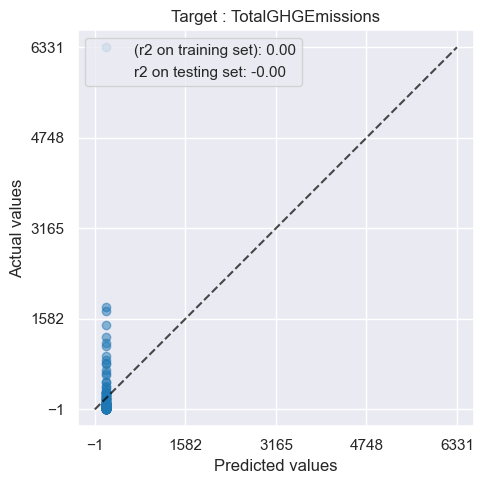

In [135]:
df = pd.read_csv('clean_data1.csv', sep=',')

cat, num, X, y_G, y_GI, dataset = unpack_data(df, 'data1')


def pipe_dummy(alea, y, strategy, scaler):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("dummy_regressor", DummyRegressor(strategy=strategy),)
        ])
    
    # Perform cross-validation (on training set) and display the scores for each split
    # Nous pourrions utiliser la fonction cross_val_score, mais 
    # cross_validate permet d'utilier plusieurs métriques.
    # Elle permet aussi d'enregistrer directement les temps de fitting et predicting 
    # sur les jeux de validation, mais nous allons plutôt comparer les temps sur les jeux de test.
    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")

    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration
    if alea == 0:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_dummy_n_times(y=y_G, strategy='mean', scaler=None):
    # Rappel modèle et cible
    print(f'Modèle : Dummy ({strategy})')
    print('target :', y.name, '\n')

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_dummy(alea=n, 
                                                                                      y=y, 
                                                                                      strategy=strategy, 
                                                                                      scaler=scaler)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Dummy (' + str(strategy) +')',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_dummy_n_times(y=y_G)
# test_dummy_n_times(y=y_GI)


### 5 Régression Ridge

Modèle : Ridge_tuned
target :  TotalGHGEmissions
Iteration  1
Best alpha: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.5951325370105063
Split 2 : r2 = 0.5708499319707991
Split 3 : r2 = 0.1150855258621738
Split 4 : r2 = -0.5342348354706603
Split 5 : r2 = 0.641280177332676
R-squared (val) =  0.27762266734109897
R-squared (train) =  0.5562610283050159
R-squared (test) =  0.5127434458536622
RMSE (val) =  608.7923837459631
RMSE (train) =  531.4052099853858
RMSE (test) =  406.2226504106548

Iteration  2
Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.35446171467216303
Split 2 : r2 = -0.3495658663218215
Split 3 : r2 = 0.40299539153826336
Split 4 : r2 = 0.17320047799405847
Split 5 : r2 = 0.4076875506037987
R-squared (val) =  0.1977558536972924
R-squared (train) =  0.5226920842381886
R-squared (test) =  -0.7530654734696312
RMSE (val) =  657.0635173628796
RMSE (train) =  564.9461756749615
RMSE (test) =  273.382397791865

{'model': 'Ridge (tuned)', 'set': 'data1', 'scaler': StandardSc

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
2,Ridge (tuned),data1,StandardScaler(),GHGEmissionsIntensity,0.365030,0.105226,1.601531,0.057638,0.461866,0.020565,1.790938,0.018319,0.400596,0.010969,1.907294,0.002186,0.007740,0.000188,0.002017,0.000045
0,Dummy (mean),data1,None,TotalGHGEmissions,-0.081558,0.080479,402.420526,179.842965,0.000000,0.000000,807.733551,9.992352,-0.041275,0.013543,809.574721,11.177423,0.004190,0.000069,0.002200,0.000203
1,Ridge (tuned),data1,StandardScaler(),TotalGHGEmissions,-0.120161,0.632904,339.802524,66.420126,0.539477,0.016784,548.175693,16.770483,0.237689,0.039933,632.927951,24.135567,0.007907,0.000238,0.002385,0.000246


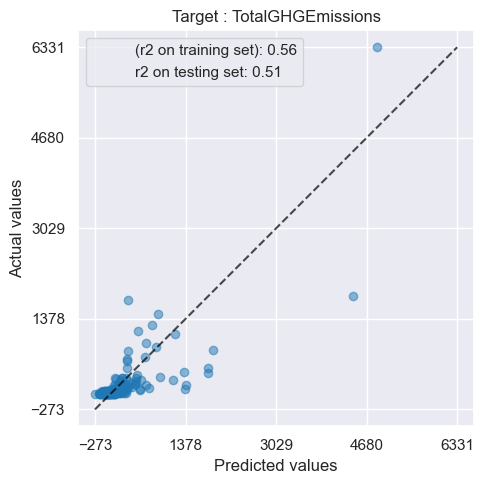

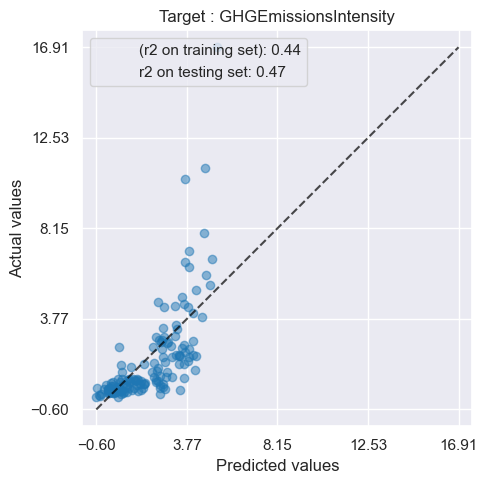

In [136]:
def pipe_ridge_tuned(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge_regressor", Ridge())
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'ridge_regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters 
    best_alpha = grid_search.best_params_['ridge_regressor__alpha']
    print(f"Best alpha: {best_alpha}")

    # Create a pipeline with the preprocessor and the tuned Ridge regressor
    pipeline_with_tuned_ridge = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ridge_regressor", Ridge(alpha=best_alpha))  # Use the tuned alpha value here
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_ridge, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_ridge, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_ridge, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_ridge.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_ridge_tuned_n_times(y=y_G, scaler=None, graph=False):
    print(f'Modèle : Ridge_tuned')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_ridge_tuned(alea=n, 
                                                                                                              y=y, 
                                                                                                              scaler=scaler,
                                                                                                              graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Ridge (tuned)',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }               
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_ridge_tuned_n_times(y=y_G, scaler=StandardScaler(), graph=True)
test_ridge_tuned_n_times(y=y_GI, scaler=StandardScaler(), graph=True)

affichage_results()


### 6 Amélioration du feature engineering

#### Scalers

In [137]:
model_results = []

scalers = [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler(quantile_range=(25, 75)),
           PowerTransformer(method="yeo-johnson"), Normalizer(),
           QuantileTransformer(output_distribution="uniform", random_state=42), 
           QuantileTransformer(output_distribution="normal", random_state=42)
           ]

for scaler in scalers:
    test_ridge_tuned_n_times(y=y_G, scaler=scaler)
    test_ridge_tuned_n_times(y=y_GI, scaler=scaler)

affichage_results()
# Meme résultat

robust = RobustScaler(quantile_range=(25, 75))


Modèle : Ridge_tuned
target :  TotalGHGEmissions
Iteration  1
Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.2909754124640238
Split 2 : r2 = 0.17967815048178215
Split 3 : r2 = 0.07420556978019377
Split 4 : r2 = -0.09820175396804642
Split 5 : r2 = 0.557619742895617
R-squared (val) =  0.20085542433071407
R-squared (train) =  0.29234287527678504
R-squared (test) =  0.029225834986429056
RMSE (val) =  673.1537925006007
RMSE (train) =  671.0787137386045
RMSE (test) =  573.3824495171062

Iteration  2
Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.23429282204467805
Split 2 : r2 = -0.0044784529823906905
Split 3 : r2 = 0.14190455911204225
Split 4 : r2 = -0.063451867954462
Split 5 : r2 = 0.17999419005660255
R-squared (val) =  0.09765225005529403
R-squared (train) =  0.2788546097098368
R-squared (test) =  0.020389309207599626
RMSE (val) =  720.066622592544
RMSE (train) =  694.4151233120897
RMSE (test) =  204.361103047088

{'model': 'Ridge (tuned)', 'set': 'data1', 'scaler':

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,Ridge (tuned),data1,MaxAbsScaler(),GHGEmissionsIntensity,0.379380,0.122804,1.577825,0.030569,0.470991,0.008843,1.776122,0.000939,0.397652,0.012443,1.901598,0.003898,0.008937,0.000281,0.002268,0.000062
9,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",GHGEmissionsIntensity,0.371768,0.120636,1.588513,0.035602,0.472517,0.008701,1.773561,0.001135,0.394496,0.014821,1.907923,0.001045,0.011671,0.001259,0.002570,0.000023
3,Ridge (tuned),data1,StandardScaler(),GHGEmissionsIntensity,0.365030,0.105226,1.601531,0.057638,0.461866,0.020565,1.790938,0.018319,0.400596,0.010969,1.907294,0.002186,0.008129,0.000505,0.002222,0.000111
11,Ridge (tuned),data1,PowerTransformer(),GHGEmissionsIntensity,0.363078,0.036427,1.619512,0.146983,0.431029,0.004893,1.842100,0.008451,0.379441,0.003206,1.946535,0.019003,0.018092,0.000808,0.002603,0.000093
5,Ridge (tuned),data1,MinMaxScaler(),GHGEmissionsIntensity,0.349362,0.092308,1.625053,0.078294,0.457623,0.023573,1.797848,0.023114,0.400615,0.011672,1.905363,0.003041,0.007591,0.001188,0.002216,0.000213
15,Ridge (tuned),data1,QuantileTransformer(random_state=42),GHGEmissionsIntensity,0.323936,0.090081,1.657870,0.087149,0.442726,0.021131,1.822517,0.018371,0.380703,0.004969,1.937171,0.007046,0.026723,0.002291,0.003029,0.000213
17,Ridge (tuned),data1,QuantileTransformer(output_distribution='norma...,GHGEmissionsIntensity,0.298672,0.094431,1.688338,0.087548,0.426308,0.021054,1.849201,0.017512,0.355860,0.002584,1.971419,0.011222,0.027736,0.000094,0.005215,0.000207
13,Ridge (tuned),data1,Normalizer(),GHGEmissionsIntensity,0.113453,0.171728,1.886688,0.040640,0.286825,0.030056,2.061621,0.025144,0.205567,0.010544,2.171478,0.002516,0.007816,0.000255,0.002217,0.000181
0,Ridge (tuned),data1,None,TotalGHGEmissions,0.024808,0.004418,388.871776,184.510673,0.285599,0.006744,682.746919,11.668205,0.149254,0.051602,696.610208,23.456415,0.007525,0.002625,0.003805,0.001345
1,Ridge (tuned),data1,None,GHGEmissionsIntensity,-0.008412,0.002652,2.045276,0.240874,0.006787,0.000472,2.433945,0.022210,0.167275,0.062277,2.272092,0.028641,0.004542,0.000105,0.002368,0.000585


#### Passage au log de y et autres transformations 

-0.8
Modèle : Ridge_tuned
target :  TotalGHGEmissions
Iteration  1
Best alpha: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.5907433878202727
Split 2 : r2 = 0.5702953921723455
Split 3 : r2 = 0.1168337381859973
Split 4 : r2 = -0.5597518422535874
Split 5 : r2 = 0.6352244222185921
R-squared (val) =  0.27066901962872403
R-squared (train) =  0.555817849989183
R-squared (test) =  0.5088731858153248
RMSE (val) =  610.2111829710301
RMSE (train) =  531.6705106552884
RMSE (test) =  407.8327648965502

Iteration  2
Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.3465682324988595
Split 2 : r2 = -0.2097407904308184
Split 3 : r2 = 0.4041351770607259
Split 4 : r2 = 0.13193145272254236
Split 5 : r2 = 0.3593267835961427
R-squared (val) =  0.20644417108949042
R-squared (train) =  0.5192728152768911
R-squared (test) =  -0.6767410934937637
RMSE (val) =  660.217679256142
RMSE (train) =  566.966104197768
RMSE (test) =  267.36495677899626

{'model': 'Ridge (tuned)', 'set': 'data1', 'scaler': Robust

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,0.000339,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,0.200048,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
0,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,-0.083934,0.592807,3.375989e+02,70.233904,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003248,0.008298,0.000174,0.002810,0.000006
1,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,-0.083934,0.592807,3.375989e+02,70.233904,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003242,0.007747,0.000354,0.002554,0.000205
3,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",y_G squared,-33.592097,33.244017,3.021327e+06,728043.144335,0.290483,0.000211,8.408604e+06,24824.885739,-12.208269,5.913169,9.279584e+06,280963.694715,0.008516,0.000205,0.002147,0.000007


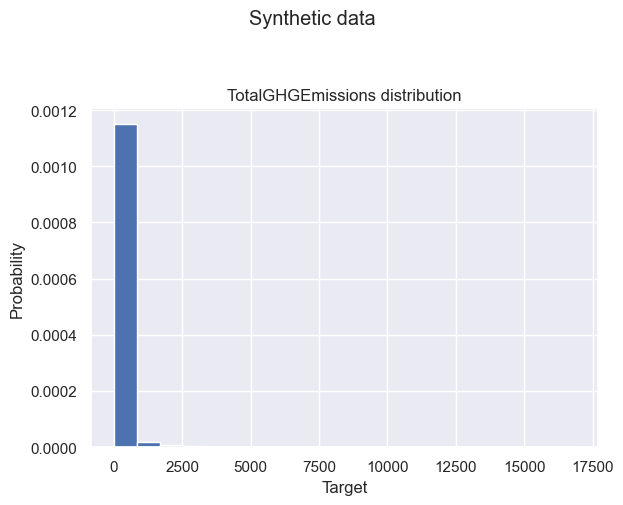

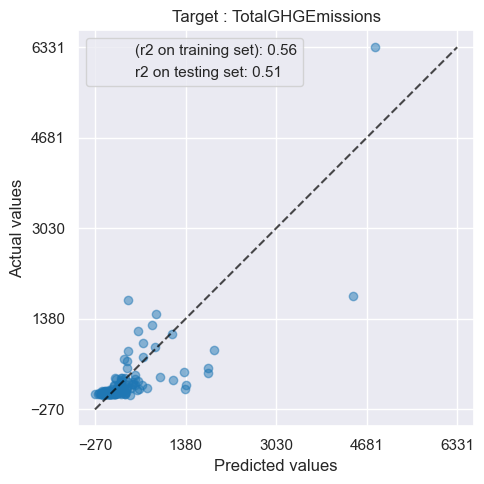

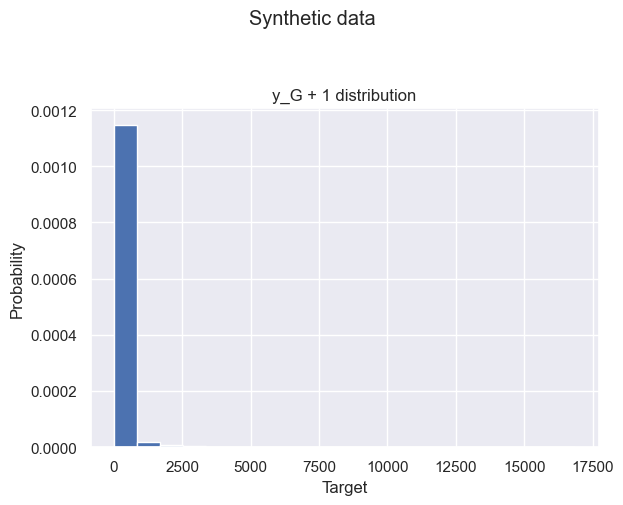

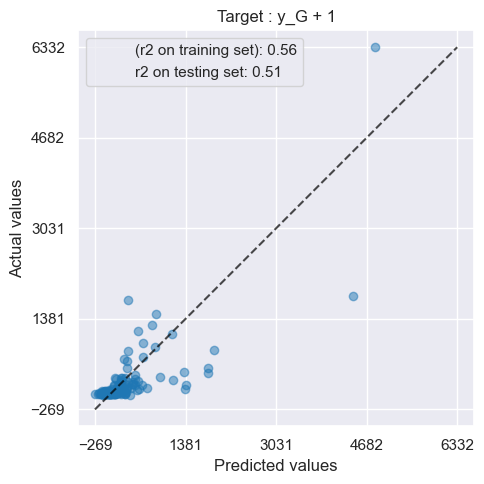

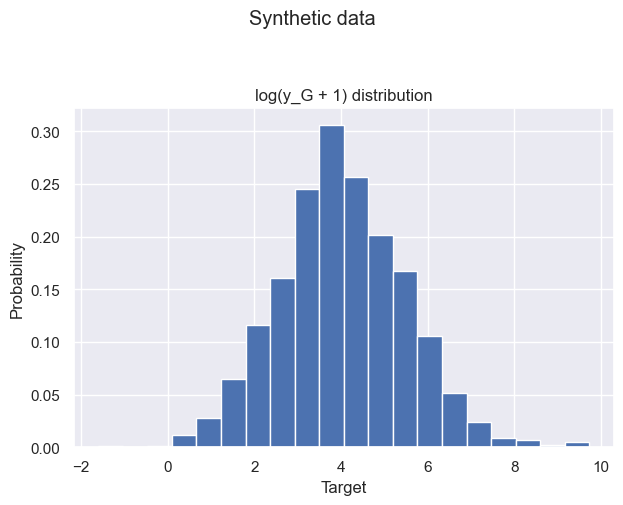

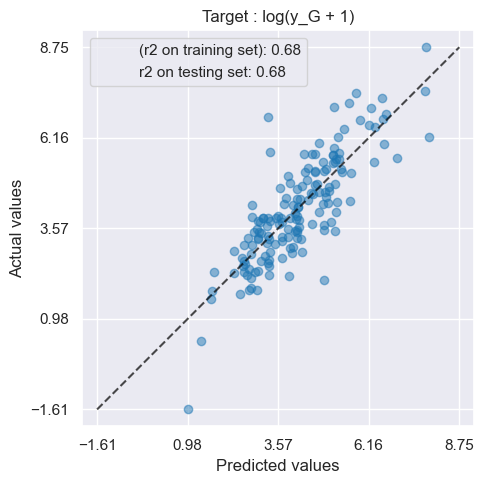

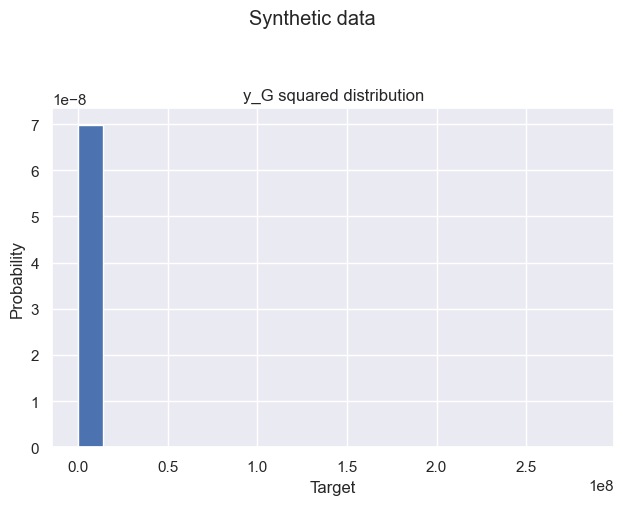

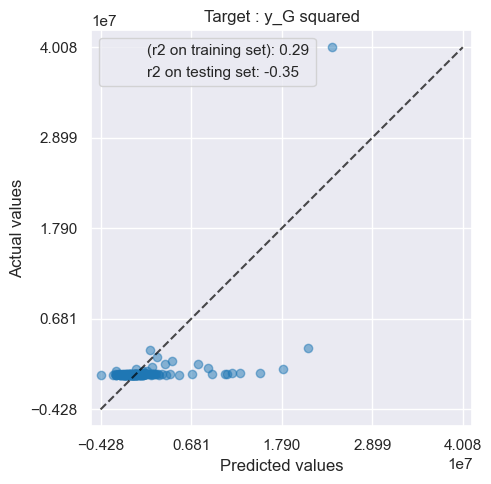

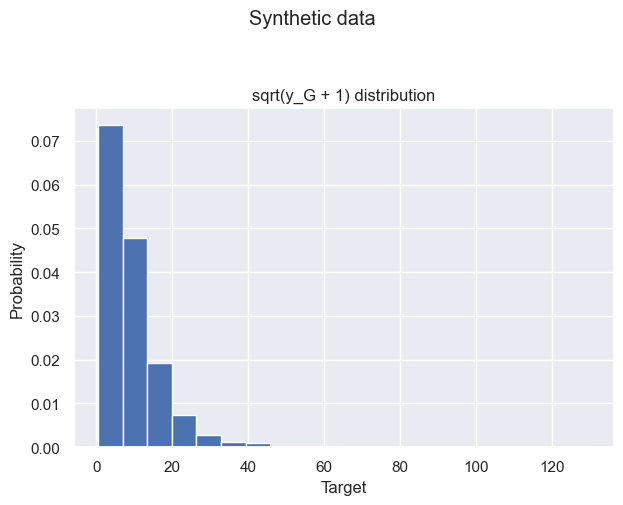

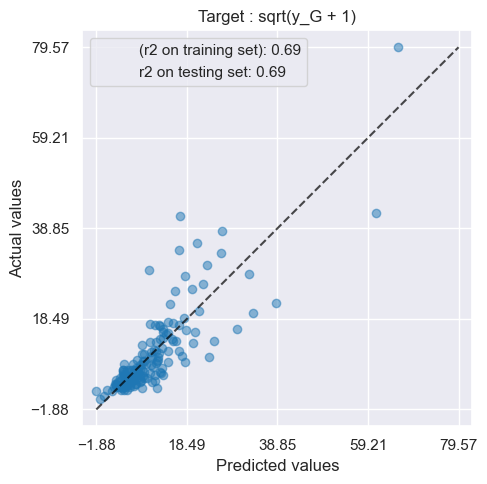

In [138]:
model_results = []

print(y_G.min())
# Attention, -0.8 < 0

y_G_translat = pd.Series(y_G + 1)
y_G_translat.name = 'y_G + 1'

y_G_log = pd.Series(np.log(y_G + 1))
y_G_log.name = 'log(y_G + 1)'

y_G_squared = pd.Series(y_G * y_G)
y_G_squared.name = 'y_G squared'

y_G_root = pd.Series(np.sqrt(y_G + 1))
y_G_root.name = 'sqrt(y_G + 1)'

transformed_target_list = [y_G, y_G_translat, y_G_log, y_G_squared, y_G_root]

for t in transformed_target_list:
    f, ax = plt.subplots(1, 1)

    ax.hist(t, bins=20, density=True)
    # ax.set_xlim([0, t.max()])
    ax.set_ylabel("Probability")
    ax.set_xlabel("Target")
    ax.set_title(f"{t.name} distribution")

    f.suptitle("Synthetic data", y=1.05)
    plt.tight_layout()
    plt.show

    test_ridge_tuned_n_times(y=t, scaler=robust, graph=True)

affichage_results()

# Aucune de ces transformations sur notre target n'est utile à notre modèle,
# Retournouns donc au feature engineering sur les variables d'entrainement.


### 7 kNN

Modèle : kNN
target :  TotalGHGEmissions
Iteration  1
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Hyperparameters: {'knn_regressor__n_neighbors': 5, 'knn_regressor__weights': 'distance'}
Cross-Validation Scores:
Split 1 : r2 = 0.5768298878868555
Split 2 : r2 = 0.5607990328681853
Split 3 : r2 = 0.08377710432158791
Split 4 : r2 = -0.0024565049460205657
Split 5 : r2 = 0.5410842028117689
R-squared (val) =  0.3520067445884754
R-squared (train) =  1.0
R-squared (test) =  0.22837198758335664
RMSE (val) =  629.3307421530201
RMSE (train) =  0.0
RMSE (test) =  511.1981616247091

Iteration  2
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Hyperparameters: {'knn_regressor__n_neighbors': 15, 'knn_regressor__weights': 'distance'}
Cross-Validation Scores:
Split 1 : r2 = 0.1387809153825207
Split 2 : r2 = 0.43695377070884456
Split 3 : r2 = 0.3747682915379805
Split 4 : r2 = 0.4418998105982439
Split 5 : r2 = 0.31170614232600435
R-squared (val) =  0.340821786110718

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,kNN,data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.651249,0.010508,8.324138e-01,8.110484e-02,1.000000,0.000000,0.000000e+00,0.000000,0.661775,0.003826,8.476374e-01,0.011109,0.008266,0.000279,0.013014,0.000204
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,3.391205e-04,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
9,kNN,data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.445357,0.129514,5.847219e+00,6.421573e-01,1.000000,0.000000,0.000000e+00,0.000000,0.563401,0.013239,6.676890e+00,0.213952,0.008579,0.000611,0.012438,0.000274
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,2.000480e-01,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
5,kNN,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.005889,0.000123,0.009809,0.000117
6,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.006493,0.000011,0.009561,0.000242
0,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003248,0.008298,0.000174,0.002810,0.000006
1,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003242,0.007747,0.000354,0.002554,0.000205
8,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G squared,-3.056856,3.064951,1.979601e+06,1.236544e+06,1.000000,0.000000,0.000000e+00,0.000000,-1.742131,1.675241,9.502538e+06,357296.027784,0.008374,0.000320,0.014429,0.001383
3,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",y_G squared,-33.592097,33.244017,3.021327e+06,7.280431e+05,0.290483,0.000211,8.408604e+06,24824.885739,-12.208269,5.913169,9.279584e+06,280963.694715,0.008516,0.000205,0.002147,0.000007


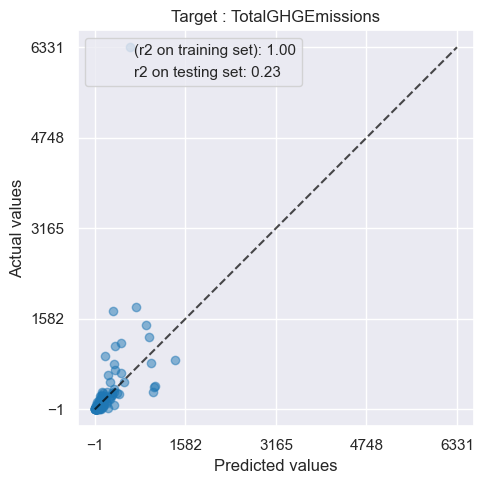

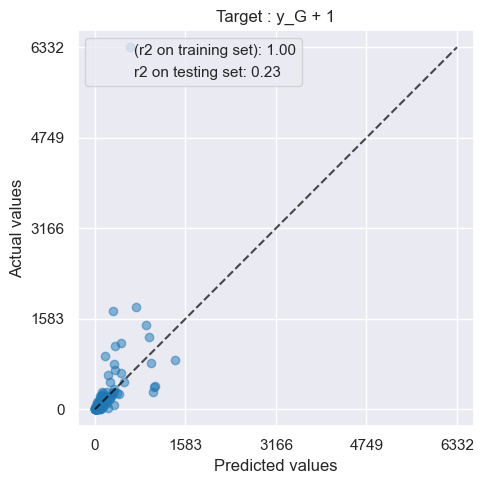

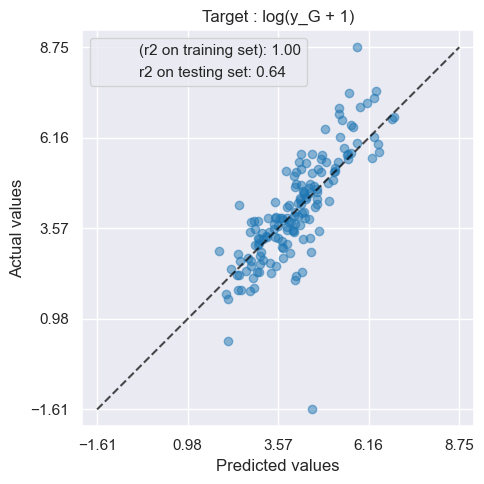

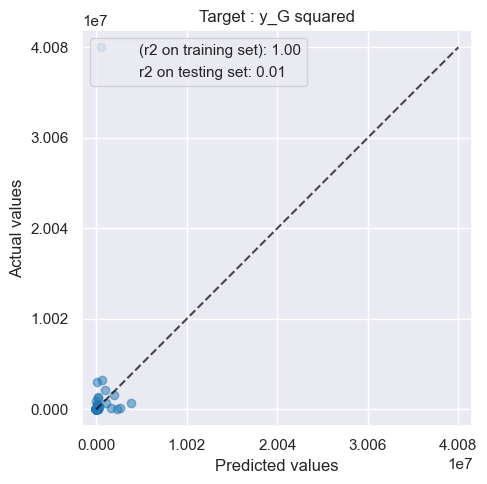

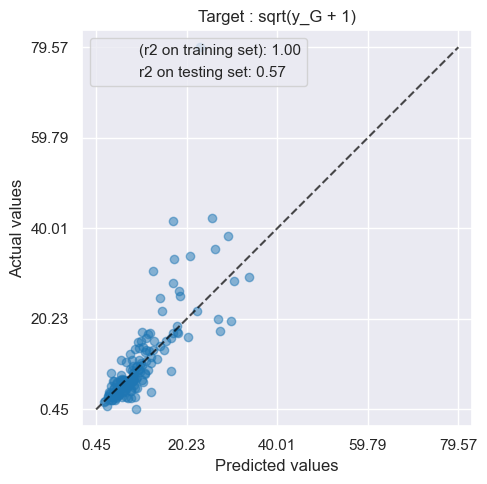

In [139]:
def pipe_knn(alea, y, scaler, graph, metric):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Create a KNN Regressor
    knn_regressor = KNeighborsRegressor(metric=metric)

    # Create a pipeline with preprocessing and a knn regressor
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("knn_regressor", knn_regressor)
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'knn_regressor__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'knn_regressor__weights': ['uniform', 'distance']
    }

    # Create the GridSearchCV object with multiple scoring metrics
    scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}
    grid_search = GridSearchCV(pipe, param_grid=param_grid, 
                            scoring=scoring, cv=5, refit='r2', verbose=1)
    
    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Create the KNN regressor with the best hyperparameters
    best_knn_regressor = KNeighborsRegressor(metric=metric,
                                             n_neighbors=best_params['knn_regressor__n_neighbors'],
                                             weights=best_params['knn_regressor__weights'])

    # Create a pipeline with the preprocessor and the tuned knn regressor
    pipeline_with_tuned_knn = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("knn_regressor", best_knn_regressor)  # Use the tuned neighbor and weight values here
    ])

    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_knn, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_knn, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_knn, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_knn.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_knn_n_times(y=y_G, scaler=robust, graph=False, metric='euclidean'):
    print(f'Modèle : kNN')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_knn(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph,
                                                                                      metric=metric)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'kNN',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


for t in transformed_target_list:
    test_knn_n_times(y=t, scaler=robust, graph=True)
    

affichage_results()


### 8 Lasso

Modèle : Lasso
target :  TotalGHGEmissions
Iteration  1
Best alpha: 1000.0
Cross-Validation Scores:
Split 1 : r2 = 0.1877811818498929
Split 2 : r2 = 0.1323519930547834
Split 3 : r2 = 0.04913465207293455
Split 4 : r2 = 0.1672666926490033
Split 5 : r2 = -0.0058598511033887135
R-squared (val) =  0.10613493370464508
R-squared (train) =  0.2022590002949729
R-squared (test) =  0.0840140160143833
RMSE (val) =  770.189803805546
RMSE (train) =  712.5133045755965
RMSE (test) =  556.9673085133518

Iteration  2
Best alpha: 1000.0
Cross-Validation Scores:
Split 1 : r2 = -0.022812883993307276
Split 2 : r2 = 0.1985484981900535
Split 3 : r2 = 0.1348578060421064
Split 4 : r2 = 0.240915403098094
Split 5 : r2 = 0.17654497535868852
R-squared (val) =  0.14561075973912702
R-squared (train) =  0.18955197738898077
R-squared (test) =  0.1205693164607583
RMSE (val) =  807.3698033812111
RMSE (train) =  736.1568170630088
RMSE (test) =  193.6298402692044

{'model': 'Lasso', 'set': 'data1', 'scaler': RobustScaler(q

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,kNN,data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.651249,0.010508,8.324138e-01,8.110484e-02,1.000000,0.000000,0.000000e+00,0.000000,0.661775,0.003826,8.476374e-01,0.011109,0.008266,0.000279,0.013014,0.000204
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,3.391205e-04,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
9,kNN,data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.445357,0.129514,5.847219e+00,6.421573e-01,1.000000,0.000000,0.000000e+00,0.000000,0.563401,0.013239,6.676890e+00,0.213952,0.008579,0.000611,0.012438,0.000274
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,2.000480e-01,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
5,kNN,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.005889,0.000123,0.009809,0.000117
6,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.006493,0.000011,0.009561,0.000242
10,Lasso,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.102292,0.018278,3.752986e+02,1.816687e+02,0.195905,0.006354,7.243351e+02,11.821756,0.125873,0.019738,7.887798e+02,18.590000,0.009641,0.000186,0.003119,0.000219
0,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003248,0.008298,0.000174,0.002810,0.000006
1,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003242,0.007747,0.000354,0.002554,0.000205
8,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G squared,-3.056856,3.064951,1.979601e+06,1.236544e+06,1.000000,0.000000,0.000000e+00,0.000000,-1.742131,1.675241,9.502538e+06,357296.027784,0.008374,0.000320,0.014429,0.001383


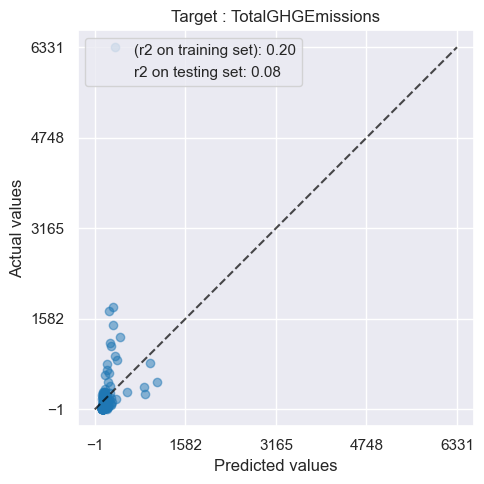

In [140]:
def pipe_lasso(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Fit and transform the preprocessor on the training data to get post-preprocessing feature names
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    # Get the feature names for the transformed data
    feature_names = preprocessor.get_feature_names_out(input_features=cat + num)

    # Define a list of alpha values for Lasso regression
    alphas = np.logspace(3, 6, 100)

    # Create a pipeline with preprocessing and LassoCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("lasso_regressor", LassoCV(alphas=alphas, cv=5, max_iter=100000))
    ])

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Access the best alpha value chosen by LassoCV
    best_alpha = pipe.named_steps['lasso_regressor'].alpha_
    print(f"Best alpha: {best_alpha}")

    # Create a pipeline with the preprocessor and the tuned Lasso regressor
    pipeline_with_tuned_lasso = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("lasso_regressor", Lasso(alpha=best_alpha, max_iter=100000))
    ])

    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_lasso, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)

    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_lasso, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_lasso, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_lasso.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_lasso_n_times(y=y_G, scaler=robust, graph=False):
    print('Modèle : Lasso')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_lasso(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Lasso',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# Run the tuned Lasso regressor
test_lasso_n_times(y=y_G, scaler=robust, graph=True)

affichage_results()


### 9 elastic net

Modèle : Elastic net
target :  TotalGHGEmissions
Iteration  1
Best alpha: 0.013257113655901095
Best l1_ratio: 1.0
Cross-Validation Scores:
Split 1 : r2 = 0.5894009768415998
Split 2 : r2 = 0.5296414658800546
Split 3 : r2 = 0.11783365015058156
Split 4 : r2 = -0.651391783602906
Split 5 : r2 = 0.7405271103308331
R-squared (val) =  0.2652022839200326
R-squared (train) =  0.5585474911347934
R-squared (test) =  0.47419309143806476
RMSE (val) =  594.3280349679003
RMSE (train) =  530.0343505709549
RMSE (test) =  421.9863806564887

Iteration  2
Best alpha: 0.001
Best l1_ratio: 1.0


Objective did not converge. You might want to increase the number of iterations. Duality gap: 823260.2556387112, tolerance: 15442.970687798754
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4084266.2084550858, tolerance: 90528.86408398676


Cross-Validation Scores:
Split 1 : r2 = 0.4709671408181272
Split 2 : r2 = -1.4235856388580368
Split 3 : r2 = 0.48454039179266917
Split 4 : r2 = -0.5226734189016427
Split 5 : r2 = 0.3747913199107522
R-squared (val) =  -0.12319204104762618
R-squared (train) =  0.57942239024411
R-squared (test) =  -3.222275529885601
RMSE (val) =  622.8415138435109
RMSE (train) =  530.3112360649341
RMSE (test) =  424.2723849011369

{'model': 'Elastic_net', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'TotalGHGEmissions', 'r2_test_moy': -1.374041219223768, 'r2_test_std': 1.8482343106618329, 'rmse_test_moy': 423.1293827788128, 'rmse_test_std': 1.1430021223241056, 'r2_train_moy': 0.5689849406894517, 'r2_train_std': 0.010437449554658307, 'rmse_train_moy': 530.1727933179445, 'rmse_train_std': 0.1384427469895968, 'r2_val_moy': 0.0710051214362032, 'r2_val_std': 0.1941971624838294, 'rmse_val_moy': 608.5847744057056, 'rmse_val_std': 14.256739437805322, 'time_fit_moy': 0.179623788000753

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,kNN,data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.651249,0.010508,8.324138e-01,8.110484e-02,1.000000,0.000000,0.000000e+00,0.000000,0.661775,0.003826,8.476374e-01,0.011109,0.008266,0.000279,0.013014,0.000204
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,3.391205e-04,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
9,kNN,data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.445357,0.129514,5.847219e+00,6.421573e-01,1.000000,0.000000,0.000000e+00,0.000000,0.563401,0.013239,6.676890e+00,0.213952,0.008579,0.000611,0.012438,0.000274
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,2.000480e-01,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
5,kNN,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.005889,0.000123,0.009809,0.000117
6,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.006493,0.000011,0.009561,0.000242
10,Lasso,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.102292,0.018278,3.752986e+02,1.816687e+02,0.195905,0.006354,7.243351e+02,11.821756,0.125873,0.019738,7.887798e+02,18.590000,0.009641,0.000186,0.003119,0.000219
0,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003248,0.008298,0.000174,0.002810,0.000006
1,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003242,0.007747,0.000354,0.002554,0.000205
11,Elastic_net,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,-1.374041,1.848234,4.231294e+02,1.143002e+00,0.568985,0.010437,5.301728e+02,0.138443,0.071005,0.194197,6.085848e+02,14.256739,0.179624,0.120056,0.003106,0.000102


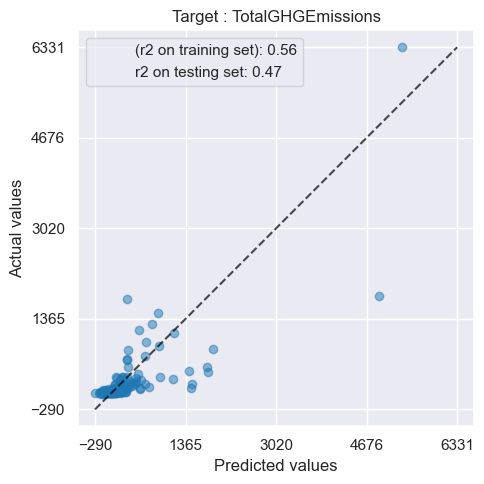

In [141]:
def pipe_elastic_net(alea, y, scaler, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Fit and transform the preprocessor on the training data to get post-preprocessing feature names
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    # Get the feature names for the transformed data
    feature_names = preprocessor.get_feature_names_out(input_features=cat + num)

    # Define a list of alpha values and l1_ratios for Elastic Net regression
    alphas = np.logspace(-3, 2, 50)
    l1_ratios = np.logspace(-1, 0, 5)

    # Create a pipeline with preprocessing and ElasticNetCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("elastic_net_regressor", ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, max_iter=10000))
    ])

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Access the best alpha value chosen by ElasticNetCV
    best_alpha = pipe.named_steps['elastic_net_regressor'].alpha_
    print(f"Best alpha: {best_alpha}")

    # Access the best l1_ratio chosen by ElasticNetCV
    best_l1_ratio = pipe.named_steps['elastic_net_regressor'].l1_ratio_
    print(f"Best l1_ratio: {best_l1_ratio}")

    # Create a pipeline with the preprocessor and the tuned Elastic Net regressor
    pipeline_with_tuned_elastic_net = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("elastic_net_regressor", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000))
    ])

    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_elastic_net, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)

    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_elastic_net, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_elastic_net, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_elastic_net.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_elastic_net_n_times(y=y_G, scaler=robust, graph=False):
    print('Modèle : Elastic net')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_elastic_net(alea=n, 
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Elastic_net',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# Run the tuned Lasso regressor
test_elastic_net_n_times(y=y_G, scaler=robust, graph=True)

affichage_results()


### 10 linear SVR

In [142]:
def pipe_linear_SVR(alea, y, scaler, graph):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)   
    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'linear_svr_regressor__C': [0.01, 0.1, 1.0, 10.0],
        'linear_svr_regressor__epsilon': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a pipeline with preprocessing and LassoCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("linear_svr_regressor", LinearSVR(dual=False, loss='squared_epsilon_insensitive'))
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_C = grid_search.best_params_['linear_svr_regressor__C']
    best_epsilon = grid_search.best_params_['linear_svr_regressor__epsilon']
    print(f"Best C: {best_C}")
    print(f"Best epsilon: {best_epsilon}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("linear_svr_regressor", LinearSVR(C=best_C, epsilon=best_epsilon, dual=False, loss='squared_epsilon_insensitive'))
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe_tuned, X_train, y_train, cv=5, scoring=scoring)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_linear_SVR_n_times(y=y_G, scaler=None, graph=False):
    print(f'Modèle : Linear SVR')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_linear_SVR(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'Linear SVR',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_linear_SVR_n_times(y=y_G, scaler=robust)
# test_linear_SVR_n_times(y=y_GI, scaler=robust)


affichage_results()

# Second best


Modèle : Linear SVR
target :  TotalGHGEmissions
Iteration  1
Best C: 1.0
Best epsilon: 0.01
Cross-Validation Scores:
Split 1 : r2 = 0.5942201089632635
Split 2 : r2 = 0.5566653236945334
Split 3 : r2 = 0.11761717174421171
Split 4 : r2 = -0.5962248746427035
Split 5 : r2 = 0.6870517117623294
R-squared (val) =  0.2718658883043269
R-squared (train) =  0.5577357386170434
R-squared (test) =  0.4957683157545223
RMSE (val) =  601.566135208832
RMSE (train) =  530.5214461250778
RMSE (test) =  413.23810043757476

Iteration  2
Best C: 0.01
Best epsilon: 0.01
Cross-Validation Scores:
Split 1 : r2 = 0.29472644592092034
Split 2 : r2 = 0.13867875561533127
Split 3 : r2 = 0.22241570923641696
Split 4 : r2 = 0.22029557143725775
Split 5 : r2 = 0.37137367290562273
R-squared (val) =  0.2494980310231098
R-squared (train) =  0.4133664392118841
R-squared (test) =  0.0806761667304855
RMSE (val) =  685.8797592250952
RMSE (train) =  626.3126841235002
RMSE (test) =  197.9728976535147

{'model': 'Linear SVR', 'set': '

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,kNN,data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.651249,0.010508,8.324138e-01,8.110484e-02,1.000000,0.000000,0.000000e+00,0.000000,0.661775,0.003826,8.476374e-01,0.011109,0.008266,0.000279,0.013014,0.000204
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,3.391205e-04,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
9,kNN,data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.445357,0.129514,5.847219e+00,6.421573e-01,1.000000,0.000000,0.000000e+00,0.000000,0.563401,0.013239,6.676890e+00,0.213952,0.008579,0.000611,0.012438,0.000274
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,2.000480e-01,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
12,Linear SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.288222,0.207546,3.056055e+02,1.076326e+02,0.485551,0.072185,5.784171e+02,47.895619,0.260682,0.011184,6.437229e+02,42.156812,0.015095,0.000376,0.006873,0.001638
5,kNN,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.005889,0.000123,0.009809,0.000117
6,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.006493,0.000011,0.009561,0.000242
10,Lasso,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.102292,0.018278,3.752986e+02,1.816687e+02,0.195905,0.006354,7.243351e+02,11.821756,0.125873,0.019738,7.887798e+02,18.590000,0.009641,0.000186,0.003119,0.000219
0,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003248,0.008298,0.000174,0.002810,0.000006
1,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003242,0.007747,0.000354,0.002554,0.000205


### 11 SVR à noyau rbf

Modèle : rbf kernel SVR
target :  TotalGHGEmissions
Iteration  1


Best C: 10.0
Best epsilon: 10.0
Best gamma: 0.01
Cross-Validation Scores:
Split 1 : r2 = 0.04967772272373994
Split 2 : r2 = 0.06705985197885145
Split 3 : r2 = 0.022759331403459093
Split 4 : r2 = 0.1765700055843139
Split 5 : r2 = 0.022362491313979938
R-squared (val) =  0.06768588060086886
R-squared (train) =  0.04614514807622161
R-squared (test) =  0.05681463021090616
RMSE (val) =  782.3956969270346
RMSE (train) =  779.1178748967798
RMSE (test) =  565.1761392454239

Iteration  2
Best C: 10.0
Best epsilon: 10.0
Best gamma: 0.1
Cross-Validation Scores:
Split 1 : r2 = -0.0026713435718626055
Split 2 : r2 = 0.24002599956474546
Split 3 : r2 = 0.0534709578163175
Split 4 : r2 = 0.20344324333243724
Split 5 : r2 = 0.1985822140456487
R-squared (val) =  0.13857021423745725
R-squared (train) =  0.04208476084313162
R-squared (test) =  0.30288587253145494
RMSE (val) =  803.761926798691
RMSE (train) =  800.3340529849809
RMSE (test) =  172.39450634373122

{'model': 'rbf kernel SVR', 'set': 'data1', 'sca

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,kNN,data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.651249,0.010508,8.324138e-01,8.110484e-02,1.000000,0.000000,0.000000e+00,0.000000,0.661775,0.003826,8.476374e-01,0.011109,0.008266,0.000279,0.013014,0.000204
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,3.391205e-04,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
9,kNN,data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.445357,0.129514,5.847219e+00,6.421573e-01,1.000000,0.000000,0.000000e+00,0.000000,0.563401,0.013239,6.676890e+00,0.213952,0.008579,0.000611,0.012438,0.000274
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,2.000480e-01,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
12,Linear SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.288222,0.207546,3.056055e+02,1.076326e+02,0.485551,0.072185,5.784171e+02,47.895619,0.260682,0.011184,6.437229e+02,42.156812,0.015095,0.000376,0.006873,0.001638
5,kNN,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.005889,0.000123,0.009809,0.000117
6,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.006493,0.000011,0.009561,0.000242
13,rbf kernel SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.179850,0.123036,3.687853e+02,1.963908e+02,0.044115,0.002030,7.897260e+02,10.608089,0.103128,0.035442,7.930788e+02,10.683115,0.072758,0.004082,0.009072,0.000190
10,Lasso,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.102292,0.018278,3.752986e+02,1.816687e+02,0.195905,0.006354,7.243351e+02,11.821756,0.125873,0.019738,7.887798e+02,18.590000,0.009641,0.000186,0.003119,0.000219
0,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,-0.083934,0.592807,3.375989e+02,7.023390e+01,0.537545,0.018273,5.493183e+02,17.647797,0.238557,0.032112,6.352144e+02,25.003248,0.008298,0.000174,0.002810,0.000006


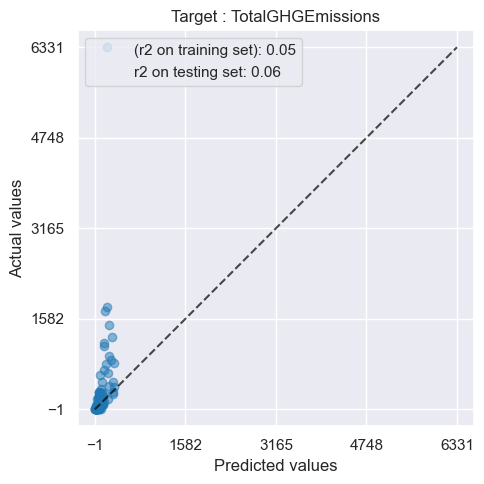

In [143]:
def pipe_rbf_kernel_SVR(alea, y, scaler, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Preprocess X_train to calculate the Gram matrix manually
    X_train_transformed = preprocessor.fit_transform(X_train)

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'rbf_svr_regressor__C': [0.01, 0.1, 1.0, 10.0],
        'rbf_svr_regressor__epsilon': [0.01, 0.1, 1.0, 10.0],
        'rbf_svr_regressor__gamma': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a pipeline with preprocessing and LassoCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("rbf_svr_regressor", SVR(kernel='rbf'))
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_C = grid_search.best_params_['rbf_svr_regressor__C']
    best_epsilon = grid_search.best_params_['rbf_svr_regressor__epsilon']
    best_gamma = grid_search.best_params_['rbf_svr_regressor__gamma']
    print(f"Best C: {best_C}")
    print(f"Best epsilon: {best_epsilon}")
    print(f"Best gamma: {best_gamma}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("rbf_svr_regressor", SVR(kernel='rbf', C=best_C, epsilon=best_epsilon, gamma=best_gamma))
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe_tuned, X_train, y_train, cv=5, scoring=scoring)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_rbf_kernel_SVR_n_times(y=y_G, scaler=None, graph=False):
    print(f'Modèle : rbf kernel SVR')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_rbf_kernel_SVR(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'rbf kernel SVR',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_rbf_kernel_SVR_n_times(y=y_G, scaler=robust, graph=True)
# test_rbf_kernel_SVR_n_times(y=y_GI, scaler=robust)


affichage_results()

### 12 kRR

Modèle : rbf krr
target :  TotalGHGEmissions
Iteration  1
Best alpha: 0.1
Best gamma: 0.01
Cross-Validation Scores:
Split 1 : r2 = 0.7342631915048062
Split 2 : r2 = 0.7924779618682398
Split 3 : r2 = 0.13849335452032763
Split 4 : r2 = -1.0735499096593308
Split 5 : r2 = 0.3933354034849267
R-squared (val) =  0.19700400034379395
R-squared (train) =  0.8060433285027132
R-squared (test) =  0.3346976432923805
RMSE (val) =  628.7550254197854
RMSE (train) =  351.32931016347834
RMSE (test) =  474.67331951843494

Iteration  2
Best alpha: 0.1
Best gamma: 0.01
Cross-Validation Scores:
Split 1 : r2 = 0.25042763777314847
Split 2 : r2 = 0.22717026971103504
Split 3 : r2 = 0.5493177153023238
Split 4 : r2 = 0.47586958700334836
Split 5 : r2 = 0.35174609268931967
R-squared (val) =  0.370906260495835
R-squared (train) =  0.7961140310840973
R-squared (test) =  -0.23632512401749972
RMSE (val) =  684.0288667604465
RMSE (train) =  369.2337783054456
RMSE (test) =  229.5819960991481

{'model': 'rbf krr', 'set': '

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,kNN,data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.651249,0.010508,8.324138e-01,8.110484e-02,1.000000,0.000000,0.000000e+00,0.000000,0.661775,0.003826,8.476374e-01,0.011109,0.008266,0.000279,0.013014,0.000204
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,3.391205e-04,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
9,kNN,data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.445357,0.129514,5.847219e+00,6.421573e-01,1.000000,0.000000,0.000000e+00,0.000000,0.563401,0.013239,6.676890e+00,0.213952,0.008579,0.000611,0.012438,0.000274
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,2.000480e-01,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
12,Linear SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.288222,0.207546,3.056055e+02,1.076326e+02,0.485551,0.072185,5.784171e+02,47.895619,0.260682,0.011184,6.437229e+02,42.156812,0.015095,0.000376,0.006873,0.001638
5,kNN,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.005889,0.000123,0.009809,0.000117
6,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.006493,0.000011,0.009561,0.000242
13,rbf kernel SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.179850,0.123036,3.687853e+02,1.963908e+02,0.044115,0.002030,7.897260e+02,10.608089,0.103128,0.035442,7.930788e+02,10.683115,0.072758,0.004082,0.009072,0.000190
10,Lasso,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.102292,0.018278,3.752986e+02,1.816687e+02,0.195905,0.006354,7.243351e+02,11.821756,0.125873,0.019738,7.887798e+02,18.590000,0.009641,0.000186,0.003119,0.000219
14,rbf krr,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.049186,0.285511,3.521277e+02,1.225457e+02,0.801079,0.004965,3.602815e+02,8.952234,0.283955,0.086951,6.563919e+02,27.636921,0.104657,0.011710,0.011254,0.000657


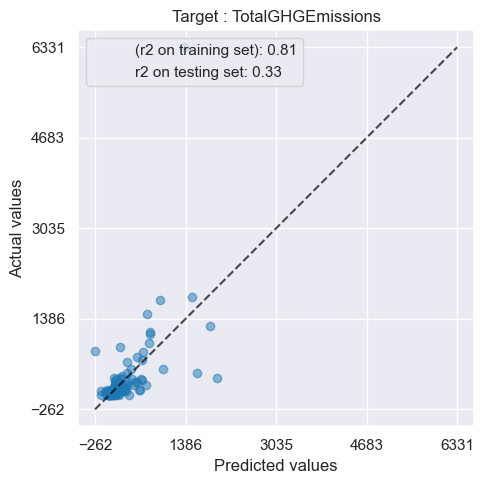

In [144]:
# la SVR est plus rapide tandis que la kRR est plus efficace ?

def pipe_rbf_krr(alea, y, scaler, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Preprocess X_train to calculate the Gram matrix manually
    X_train_transformed = preprocessor.fit_transform(X_train)

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'krr_regressor__alpha': [0.01, 0.1, 1.0, 10.0],
        'krr_regressor__gamma': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a pipeline with preprocessing and LassoCV for hyperparameter tuning
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("krr_regressor", KernelRidge(kernel='rbf'))
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters and best estimator
    best_alpha = grid_search.best_params_['krr_regressor__alpha']
    best_gamma = grid_search.best_params_['krr_regressor__gamma']
    print(f"Best alpha: {best_alpha}")
    print(f"Best gamma: {best_gamma}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("krr_regressor", KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma))
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipe_tuned, X_train, y_train, cv=5, scoring=scoring)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_rbf_krr_n_times(y=y_G, scaler=None, graph=False):
    print(f'Modèle : rbf krr')
    print('target : ', y.name)

    results_r2_val, results_rmse_val,  results_r2_train, results_rmse_train = [], [], [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_val, rmse_val, r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_rbf_krr(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph)
        results_r2_val.append(r2_val)
        results_rmse_val.append(rmse_val)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_val_moy = np.mean(results_r2_val)
    rmse_val_moy = np.mean(results_rmse_val)
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_val_std = np.std(results_r2_val)
    rmse_val_std = np.std(results_rmse_val)
    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'rbf krr',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'r2_val_moy': r2_val_moy,
               'r2_val_std': r2_val_std,
               'rmse_val_moy': rmse_val_moy,
               'rmse_val_std': rmse_val_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_rbf_krr_n_times(y=y_G, scaler=robust, graph=True)
# test_rbf_krr_n_times(y=y_GI, scaler=robust)


affichage_results()

# Bcp + rapide que rbf kernel svr,
# pas de gain / linear tuned ridge

# Meilleur r2, Gram matrix plus étalée


### 13 Random forest

Modèle : random forest
target :  TotalGHGEmissions
Iteration  1
best_n_estimators: 100
best_max_depth: None
best_min_samples_split: 5
best_min_samples_leaf: 2
best_max_features: sqrt
R-squared (train) =  0.6736251670852694
R-squared (test) =  0.5930160988050015
RMSE (train) =  455.7433632067149
RMSE (test) =  371.25636302860863

Iteration  2
best_n_estimators: 300
best_max_depth: None
best_min_samples_split: 2
best_min_samples_leaf: 1
best_max_features: sqrt
R-squared (train) =  0.9228114612713452
R-squared (test) =  -0.5407609486745615
RMSE (train) =  227.18735968789372
RMSE (test) =  256.29439666834236

{'model': 'random forest tuned', 'set': 'data1', 'scaler': None, 'target': 'TotalGHGEmissions', 'r2_test_moy': 0.02612757506522001, 'r2_test_std': 0.5668885237397815, 'rmse_test_moy': 313.7753798484755, 'rmse_test_std': 57.48098318013314, 'r2_train_moy': 0.7982183141783072, 'r2_train_std': 0.12459314709303787, 'rmse_train_moy': 341.4653614473043, 'rmse_train_std': 114.27800175941059, 

,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,kNN,data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.651249,0.010508,8.324138e-01,8.110484e-02,1.000000,0.000000,0.000000e+00,0.000000,0.661775,0.003826,8.476374e-01,0.011109,0.008266,0.000279,0.013014,0.000204
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,3.391205e-04,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
9,kNN,data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.445357,0.129514,5.847219e+00,6.421573e-01,1.000000,0.000000,0.000000e+00,0.000000,0.563401,0.013239,6.676890e+00,0.213952,0.008579,0.000611,0.012438,0.000274
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,2.000480e-01,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
12,Linear SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.288222,0.207546,3.056055e+02,1.076326e+02,0.485551,0.072185,5.784171e+02,47.895619,0.260682,0.011184,6.437229e+02,42.156812,0.015095,0.000376,0.006873,0.001638
5,kNN,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.005889,0.000123,0.009809,0.000117
6,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.006493,0.000011,0.009561,0.000242
13,rbf kernel SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.179850,0.123036,3.687853e+02,1.963908e+02,0.044115,0.002030,7.897260e+02,10.608089,0.103128,0.035442,7.930788e+02,10.683115,0.072758,0.004082,0.009072,0.000190
10,Lasso,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.102292,0.018278,3.752986e+02,1.816687e+02,0.195905,0.006354,7.243351e+02,11.821756,0.125873,0.019738,7.887798e+02,18.590000,0.009641,0.000186,0.003119,0.000219
14,rbf krr,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.049186,0.285511,3.521277e+02,1.225457e+02,0.801079,0.004965,3.602815e+02,8.952234,0.283955,0.086951,6.563919e+02,27.636921,0.104657,0.011710,0.011254,0.000657


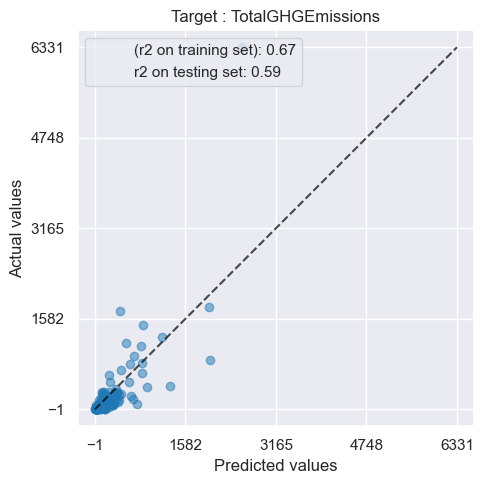

In [145]:
def pipe_forest(alea, y, graph):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=None)

    # Define the hyperparameter grid
    param_grid = {
        'forest_regressor__n_estimators': [100, 300],
        'forest_regressor__max_depth': [None, 10, 30],
        'forest_regressor__min_samples_split': [2, 5, 10],
        'forest_regressor__min_samples_leaf': [1, 2],
        'forest_regressor__max_features': ['sqrt']
    }

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("forest_regressor", RandomForestRegressor())
    ])

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters and best estimator
    best_n_estimators = grid_search.best_params_['forest_regressor__n_estimators']
    best_max_depth = grid_search.best_params_['forest_regressor__max_depth']
    best_min_samples_split = grid_search.best_params_['forest_regressor__min_samples_split']
    best_min_samples_leaf = grid_search.best_params_['forest_regressor__min_samples_leaf']
    best_max_features = grid_search.best_params_['forest_regressor__max_features']
    print(f"best_n_estimators: {best_n_estimators}")
    print(f"best_max_depth: {best_max_depth}")
    print(f"best_min_samples_split: {best_min_samples_split}")
    print(f"best_min_samples_leaf: {best_min_samples_leaf}")
    print(f"best_max_features: {best_max_features}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("forest_regressor", RandomForestRegressor(n_estimators=best_n_estimators,
                                                   max_depth=best_max_depth,
                                                   min_samples_split=best_min_samples_split,
                                                   min_samples_leaf=best_min_samples_leaf,
                                                   max_features=best_max_features))
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_forest_n_times(y=y_G,graph=True):
    print(f'Modèle : random forest')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_forest(alea=n,
                                                                                      y=y, 
                                                                                      graph=graph)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'random forest tuned',
               'set': dataset,
               'scaler': None,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_forest_n_times(y=y_G, graph=True)


affichage_results()


### 14 XGBoost

In [146]:
# Random search

def pipe_xgb(alea, y, graph, scaler):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Define the hyperparameter grid for RandomizedSearch
    param_dist = {
        'xgb_regressor__n_estimators': randint(100, 1000),
        'xgb_regressor__learning_rate': uniform(0.01, 0.2),
        'xgb_regressor__max_depth': randint(3, 10),
        'xgb_regressor__min_child_weight': randint(1, 5),
        'xgb_regressor__subsample': uniform(0.7, 0.3),
        'xgb_regressor__colsample_bytree': uniform(0.7, 0.3),
        'xgb_regressor__gamma': uniform(0, 0.5),
        'xgb_regressor__reg_alpha': uniform(0, 1),
        'xgb_regressor__reg_lambda': uniform(0, 1)
    }

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("xgb_regressor", XGBRegressor())
    ])

    # Create a RandomizedSearchCV object
    randomized_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=100, cv=5, scoring='r2', n_jobs=-1, random_state=42)

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    randomized_search.fit(X_train, y_train)

    # Access the best hyperparameters
    best_n_estimators = randomized_search.best_params_['gradient_regressor__n_estimators']
    best_learning_rate = randomized_search.best_params_['gradient_regressor__learning_rate']
    best_max_depth = randomized_search.best_params_['gradient_regressor__max_depth']
    best_min_samples_split = randomized_search.best_params_['gradient_regressor__min_samples_split']
    best_min_samples_leaf = randomized_search.best_params_['gradient_regressor__min_samples_leaf']
    best_max_features = randomized_search.best_params_['gradient_regressor__max_features']
    best_subsample = randomized_search.best_params_['gradient_regressor__subsample']

    print(f"Best n_estimators: {best_n_estimators}")
    print(f"Best learning_rate: {best_learning_rate}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best min_samples_split: {best_min_samples_split}")
    print(f"Best min_samples_leaf: {best_min_samples_leaf}")
    print(f"Best max_features: {best_max_features}")
    print(f"Best subsample: {best_subsample}")

    # Create a pipeline with the preprocessor and the tuned regressor
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("gradient_regressor", GradientBoostingRegressor(
            n_estimators=best_n_estimators,
            learning_rate=best_learning_rate,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split,
            min_samples_leaf=best_min_samples_leaf,
            max_features=best_max_features,
            subsample=best_subsample))
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_xgb_n_times(y=y_G, graph=True, scaler=robust):
    print(f'Modèle : xgboost')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_xgb(alea=n,
                                                                                      y=y, 
                                                                                      graph=graph,
                                                                                      scaler=scaler)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'xgboost',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


# test_xgb_n_times(graph=True, scaler=robust)


# affichage_results()


Modèle : xgboost
target :  TotalGHGEmissions
Iteration  1


R-squared (train) =  0.9826706622345681
R-squared (test) =  0.622319269758425
RMSE (train) =  105.01540340185824
RMSE (test) =  357.6413323938757

Iteration  2
R-squared (train) =  0.9811689916745566
R-squared (test) =  -0.20570518070234334
RMSE (train) =  112.21335373008503
RMSE (test) =  226.72115408249195

{'model': 'xgboost dft', 'set': 'data1', 'scaler': RobustScaler(quantile_range=(25, 75)), 'target': 'TotalGHGEmissions', 'r2_test_moy': 0.20830704452804083, 'r2_test_std': 0.41401222523038417, 'rmse_test_moy': 292.1812432381838, 'rmse_test_std': 65.46008915569188, 'r2_train_moy': 0.9819198269545624, 'r2_train_std': 0.0007508352800057461, 'rmse_train_moy': 108.61437856597163, 'rmse_train_std': 3.598975164113398, 'time_fit_moy': 0.23454623950055975, 'time_fit_std': 0.018843558502339874, 'time_predict_moy': 0.003422658000999945, 'time_predict_std': 0.00014335999912873376} 



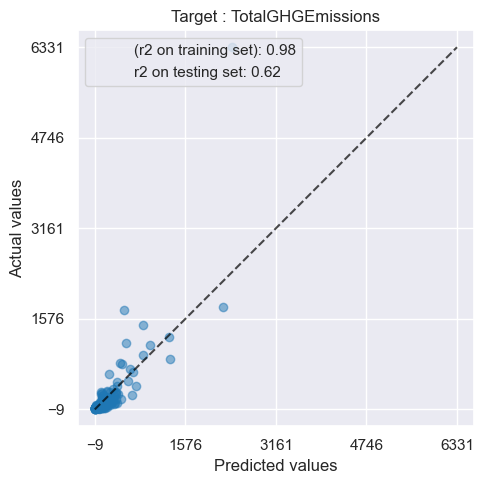

In [147]:
# default parameters

def pipe_xgb(alea, y, graph, scaler):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Create a pipeline 
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("gradient_regressor", GradientBoostingRegressor())
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_xgb_n_times(y=y_G, graph=True, scaler=robust):
    print(f'Modèle : xgboost')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_xgb(alea=n,
                                                                                      y=y, 
                                                                                      graph=graph,
                                                                                      scaler=scaler)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'xgboost dft',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')

    # Append a new row for this model
    model_results.append(results)


test_xgb_n_times(graph=True, scaler=robust)


### 15 Comparaison, Modèle choisi

In [148]:
affichage_results()


,model,set,scaler,target,r2_test_moy,r2_test_std,rmse_test_moy,rmse_test_std,r2_train_moy,r2_train_std,rmse_train_moy,rmse_train_std,r2_val_moy,r2_val_std,rmse_val_moy,rmse_val_std,time_fit_moy,time_fit_std,time_predict_moy,time_predict_std
7,kNN,data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.651249,0.010508,8.324138e-01,8.110484e-02,1.000000,0.000000,0.000000e+00,0.000000,0.661775,0.003826,8.476374e-01,0.011109,0.008266,0.000279,0.013014,0.000204
2,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",log(y_G + 1),0.621795,0.062262,8.570171e-01,3.391205e-04,0.687836,0.005650,8.166036e-01,0.000363,0.371000,0.039438,1.193720e+00,0.017080,0.008970,0.000165,0.002725,0.000007
9,kNN,data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.445357,0.129514,5.847219e+00,6.421573e-01,1.000000,0.000000,0.000000e+00,0.000000,0.563401,0.013239,6.676890e+00,0.213952,0.008579,0.000611,0.012438,0.000274
4,Ridge (tuned),data1,"RobustScaler(quantile_range=(25, 75))",sqrt(y_G + 1),0.399274,0.290729,5.741476e+00,2.000480e-01,0.700923,0.012253,5.431491e+00,0.021177,0.459685,0.060301,7.766344e+00,0.288367,0.008779,0.000350,0.002501,0.000324
12,Linear SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.288222,0.207546,3.056055e+02,1.076326e+02,0.485551,0.072185,5.784171e+02,47.895619,0.260682,0.011184,6.437229e+02,42.156812,0.015095,0.000376,0.006873,0.001638
5,kNN,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.005889,0.000123,0.009809,0.000117
6,kNN,data1,"RobustScaler(quantile_range=(25, 75))",y_G + 1,0.221554,0.006818,3.470840e+02,1.641142e+02,1.000000,0.000000,0.000000e+00,0.000000,0.346414,0.005592,6.818429e+02,52.512110,0.006493,0.000011,0.009561,0.000242
16,xgboost dft,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.208307,0.414012,2.921812e+02,6.546009e+01,0.981920,0.000751,1.086144e+02,3.598975,NaN,NaN,NaN,NaN,0.234546,0.018844,0.003423,0.000143
13,rbf kernel SVR,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.179850,0.123036,3.687853e+02,1.963908e+02,0.044115,0.002030,7.897260e+02,10.608089,0.103128,0.035442,7.930788e+02,10.683115,0.072758,0.004082,0.009072,0.000190
10,Lasso,data1,"RobustScaler(quantile_range=(25, 75))",TotalGHGEmissions,0.102292,0.018278,3.752986e+02,1.816687e+02,0.195905,0.006354,7.243351e+02,11.821756,0.125873,0.019738,7.887798e+02,18.590000,0.009641,0.000186,0.003119,0.000219


### 16 Interprétation, importance de la feature 'ENERGYSTARSscore'

In [149]:
df = pd.read_csv('star_score_subset.csv', sep=',')

print(df.shape)
display(df.head())

cat, num, X, y_G, y_GI, dataset = unpack_data(df, 'data8')


(997, 16)


,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,proportion_parking,proportion_electricity,proportion_gaz,proportion_steam,SiteEnergyUse(kBtu),SiteEUI(kBtu/sf),TotalGHGEmissions,GHGEmissionsIntensity,star_score
0,NonResidential,Hotel,DOWNTOWN,1927,1.0,12,88434,0.000000,0.546060,0.176638,0.277302,7226362.5,81.699997,249.98,2.83,60.0
1,NonResidential,Hotel,DOWNTOWN,1996,1.0,11,103566,0.145453,0.386609,0.613391,0.000000,8387933.0,94.800003,295.86,2.86,61.0
2,NonResidential,Hotel,DOWNTOWN,1969,1.0,41,956110,0.205748,0.682307,0.020579,0.297113,72587024.0,96.000000,2089.28,2.19,43.0
3,NonResidential,Hotel,DOWNTOWN,1926,1.0,10,61320,0.000000,0.407519,0.266567,0.325913,6794584.0,110.800003,286.43,4.67,56.0
4,NonResidential,Hotel,DOWNTOWN,1980,1.0,18,175580,0.353115,0.378802,0.621198,0.000000,14172606.0,114.800003,505.01,2.88,75.0


#### Coefficients (modèles linéaires)

Best alpha: 10.0
Cross-Validation Scores:
Split 1 : r2 = 0.6825915372538771
Split 2 : r2 = 0.7447703477207085
Split 3 : r2 = 0.06410579448589127
Split 4 : r2 = -2.7997204309586343
Split 5 : r2 = 0.8434606433899487
R-squared (val) =  -0.09295842162164174
R-squared (train) =  0.5804039218089996
R-squared (test) =  -5.998085604001172
RMSE (val) =  684.6149826376572
RMSE (train) =  586.5506079222486
RMSE (test) =  499.61836354887896



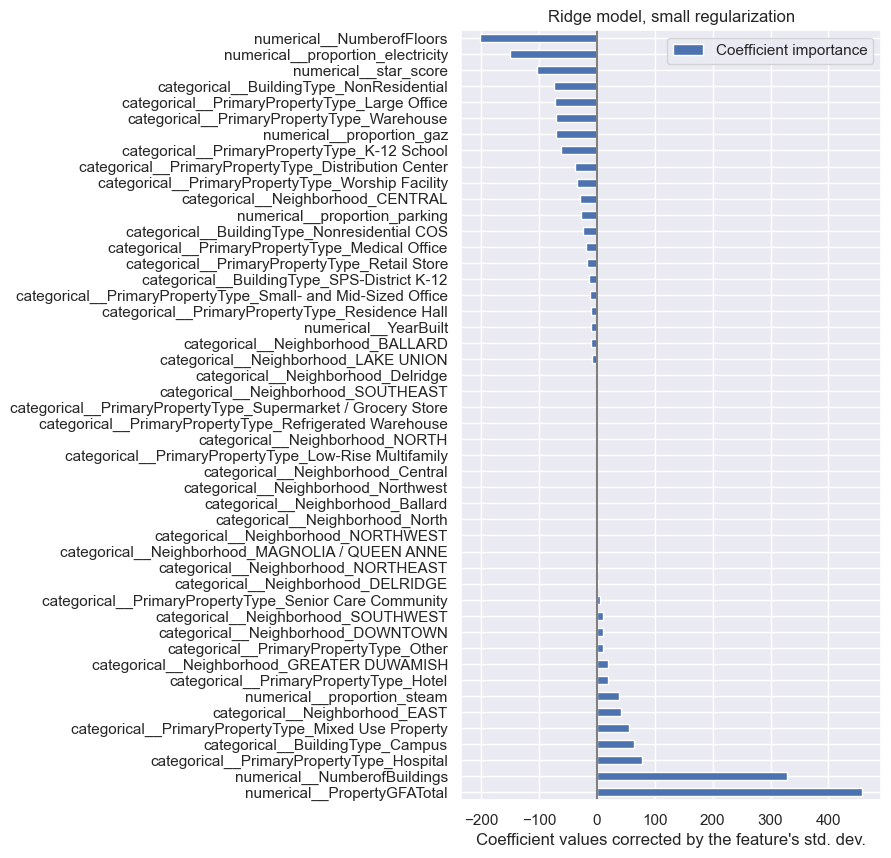

In [150]:
# avec coeffs pondérés par la variance des features 
# -> permet de comparer l'importance relative des features selon ce modèle.

def pipe_ridge_coeffs(y, graph=False):

    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=42, test_size=test_size, \
                                                                    scaler=robust)   
    # Dernière étape du pipeline (notre modèle)
    pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge_regressor", Ridge())
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'ridge_regressor__alpha': [0.01, 0.1, 1.0, 10.0]
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Access the best hyperparameters 
    best_alpha = grid_search.best_params_['ridge_regressor__alpha']
    print(f"Best alpha: {best_alpha}")

    # Create a pipeline with the preprocessor and the tuned Ridge regressor
    pipeline_with_tuned_ridge = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("ridge_regressor", Ridge(alpha=best_alpha))  # Use the tuned alpha value here
    ])
    
    # Perform cross-validation (on training set) and display the scores for each split    
    scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_ridge, X_train, y_train, cv=5, scoring=scoring)
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    for i, score in enumerate(cv_scores['test_r2']):
        print(f"Split {i+1} : r2 = {score}")
    
    r2_val = cv_scores['test_r2'].mean()
    mse_val = -cv_scores['test_neg_mean_squared_error'].mean()
    rmse_val = np.sqrt(mse_val)
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipeline_with_tuned_ridge, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipeline_with_tuned_ridge, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipeline_with_tuned_ridge.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (val) =  {r2_val}")
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (val) =  {rmse_val}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # Preprocess the training data
    X_train_preprocessed = pipeline_with_tuned_ridge.named_steps['preprocessor'].transform(X_train)
    feature_names = pipeline_with_tuned_ridge.named_steps['preprocessor'].get_feature_names_out()

    # If X_train_preprocessed is a sparse matrix, convert it to a dense matrix for std calculation
    X_train_preprocessed = X_train_preprocessed.toarray()

    #  Calculate the coefficients
    coefs = pd.DataFrame(
        pipeline_with_tuned_ridge.named_steps['ridge_regressor'].coef_ * np.std(X_train_preprocessed, axis=0),
        columns=["Coefficient importance"],
        index=feature_names,
    )
    
    # Sort the DataFrame 
    coefs.sort_values(by='Coefficient importance', ascending=False, inplace=True)

    coefs.plot(kind="barh", figsize=(7, 10))
    plt.xlabel("Coefficient values corrected by the feature's std. dev.")
    plt.title("Ridge model, small regularization")
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)


pipe_ridge_coeffs(y_G)


#### SelectFromModel(), feature_importances_

Modèle : random forest
target :  TotalGHGEmissions
Iteration  1
R-squared (train) =  0.9137448193714284
R-squared (test) =  0.8872250476337172
RMSE (train) =  254.24874959510254
RMSE (test) =  275.6037223388996

nb features after selection :  15
feature_importances_['star_score'] =  0.03004014067976734


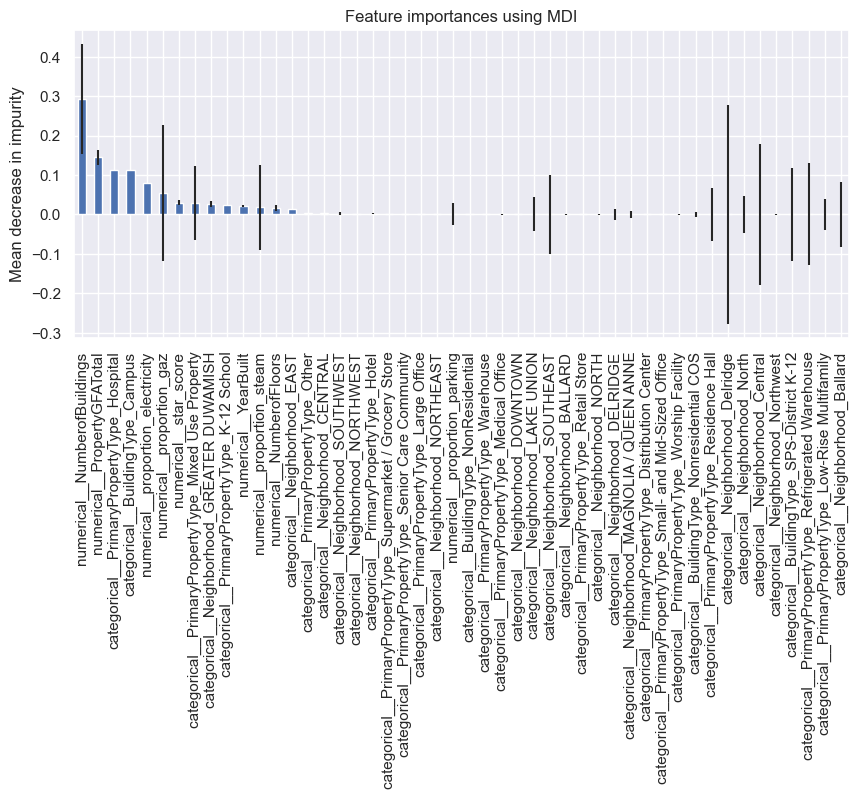

Iteration  2
R-squared (train) =  0.8945563704367817
R-squared (test) =  0.778139855899353
RMSE (train) =  273.43199911875314
RMSE (test) =  477.2227260727902

nb features after selection :  16
feature_importances_['star_score'] =  0.04588565985910906


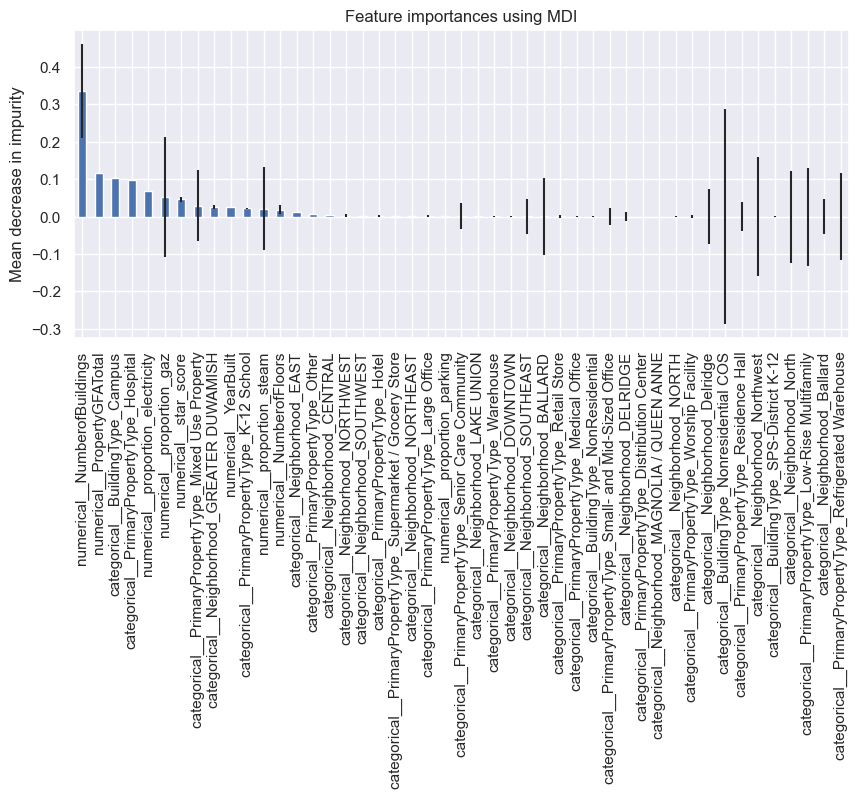

{'model': 'random forest', 'set': 'data8', 'scaler': None, 'target': 'TotalGHGEmissions', 'r2_test_moy': 0.8326824517665351, 'r2_test_std': 0.05454259586718213, 'rmse_test_moy': 376.4132242058449, 'rmse_test_std': 100.80950186694528, 'r2_train_moy': 0.9041505949041051, 'r2_train_std': 0.009594224467323331, 'rmse_train_moy': 263.84037435692784, 'rmse_train_std': 9.591624761825301, 'time_fit_moy': 4.548741956998128, 'time_fit_std': 0.0830628469993826, 'time_predict_moy': 0.03160904400101572, 'time_predict_std': 0.001119128000937053} 



In [154]:
def pipe_forest(alea, y, scaler, graph, input_features):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Our model
    rfr = RandomForestRegressor(n_estimators=500, oob_score=True)

    # Create a pipeline 
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("forest_regressor", rfr)
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    select = SelectFromModel(rfr, prefit=True, threshold=0.003)

    # Fit and transform the preprocessor on the training data to get post-preprocessing feature names
    X_train_transformed = preprocessor.fit_transform(X_train)

    X_train2 = select.transform(X_train_transformed)
    print('nb features after selection : ', X_train2.shape[1])

    feature_names = preprocessor.get_feature_names_out(input_features=input_features)
    # print(feature_names)

    importances = rfr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)
    print("feature_importances_['star_score'] = ", forest_importances['numerical__star_score'])

    # Sort the feature importances by mean decrease in impurity
    sorted_importances = forest_importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 4))  

    sorted_importances.plot.bar(yerr=std)
    plt.title("Feature importances using MDI")
    plt.ylabel("Mean decrease in impurity")

    plt.show()


    # Return scores for this random state
    return r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict


def test_forest_n_times(y=y_G, scaler=None, graph=True, input_features=cat + num):
    print(f'Modèle : random forest')
    print('target : ', y.name)

    results_r2_train, results_rmse_train = [], []
    results_r2_test, results_rmse_test, results_time_fit, results_time_predict = [], [], [], []

    for n in range(nb_iter):
        print('Iteration ', n+1)
        r2_train, rmse_train, r2_test, rmse_test, time_fit, time_predict = pipe_forest(alea=n,
                                                                                      y=y, 
                                                                                      scaler=scaler,
                                                                                      graph=graph,
                                                                                      input_features=input_features)
        results_r2_train.append(r2_train)
        results_rmse_train.append(rmse_train)
        results_r2_test.append(r2_test)
        results_rmse_test.append(rmse_test)
        results_time_fit.append(time_fit)
        results_time_predict.append(time_predict)

    # Calculate means and std devs
    r2_train_moy = np.mean(results_r2_train)
    rmse_train_moy = np.mean(results_rmse_train)
    r2_test_moy = np.mean(results_r2_test)
    rmse_test_moy = np.mean(results_rmse_test)
    time_fit_moy = np.mean(results_time_fit)
    time_predict_moy = np.mean(results_time_predict)

    r2_train_std = np.std(results_r2_train)
    rmse_train_std = np.std(results_rmse_train)
    r2_test_std = np.std(results_r2_test)
    rmse_test_std = np.std(results_rmse_test)
    time_fit_std = np.std(results_time_fit)
    time_predict_std = np.std(results_time_predict)

    # Mise en forme
    results = {'model': 'random forest',
               'set': dataset,
               'scaler': scaler,
               'target': y.name,
               'r2_test_moy': r2_test_moy,
               'r2_test_std': r2_test_std,
               'rmse_test_moy': rmse_test_moy,
               'rmse_test_std': rmse_test_std,
               'r2_train_moy': r2_train_moy,
               'r2_train_std': r2_train_std,
               'rmse_train_moy': rmse_train_moy,
               'rmse_train_std': rmse_train_std,
               'time_fit_moy': time_fit_moy,
               'time_fit_std': time_fit_std,
               'time_predict_moy': time_predict_moy,
               'time_predict_std': time_predict_std,
               }
    
    print(results, '\n')


test_forest_n_times(scaler=None, graph=False, input_features=cat + num)


#### SHAP

R-squared (train) =  0.9957412758574781
R-squared (test) =  0.25495492452794344
RMSE (train) =  59.0921149424448
RMSE (test) =  163.0196819379272

Interprétation globale


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


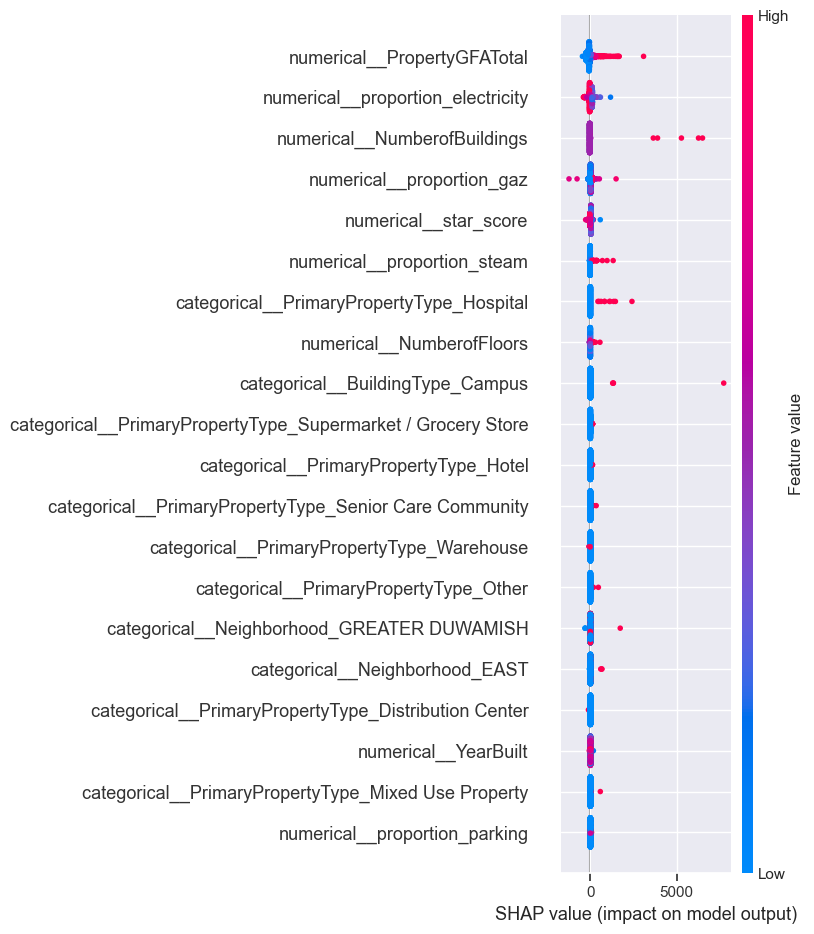

Interprétation locale


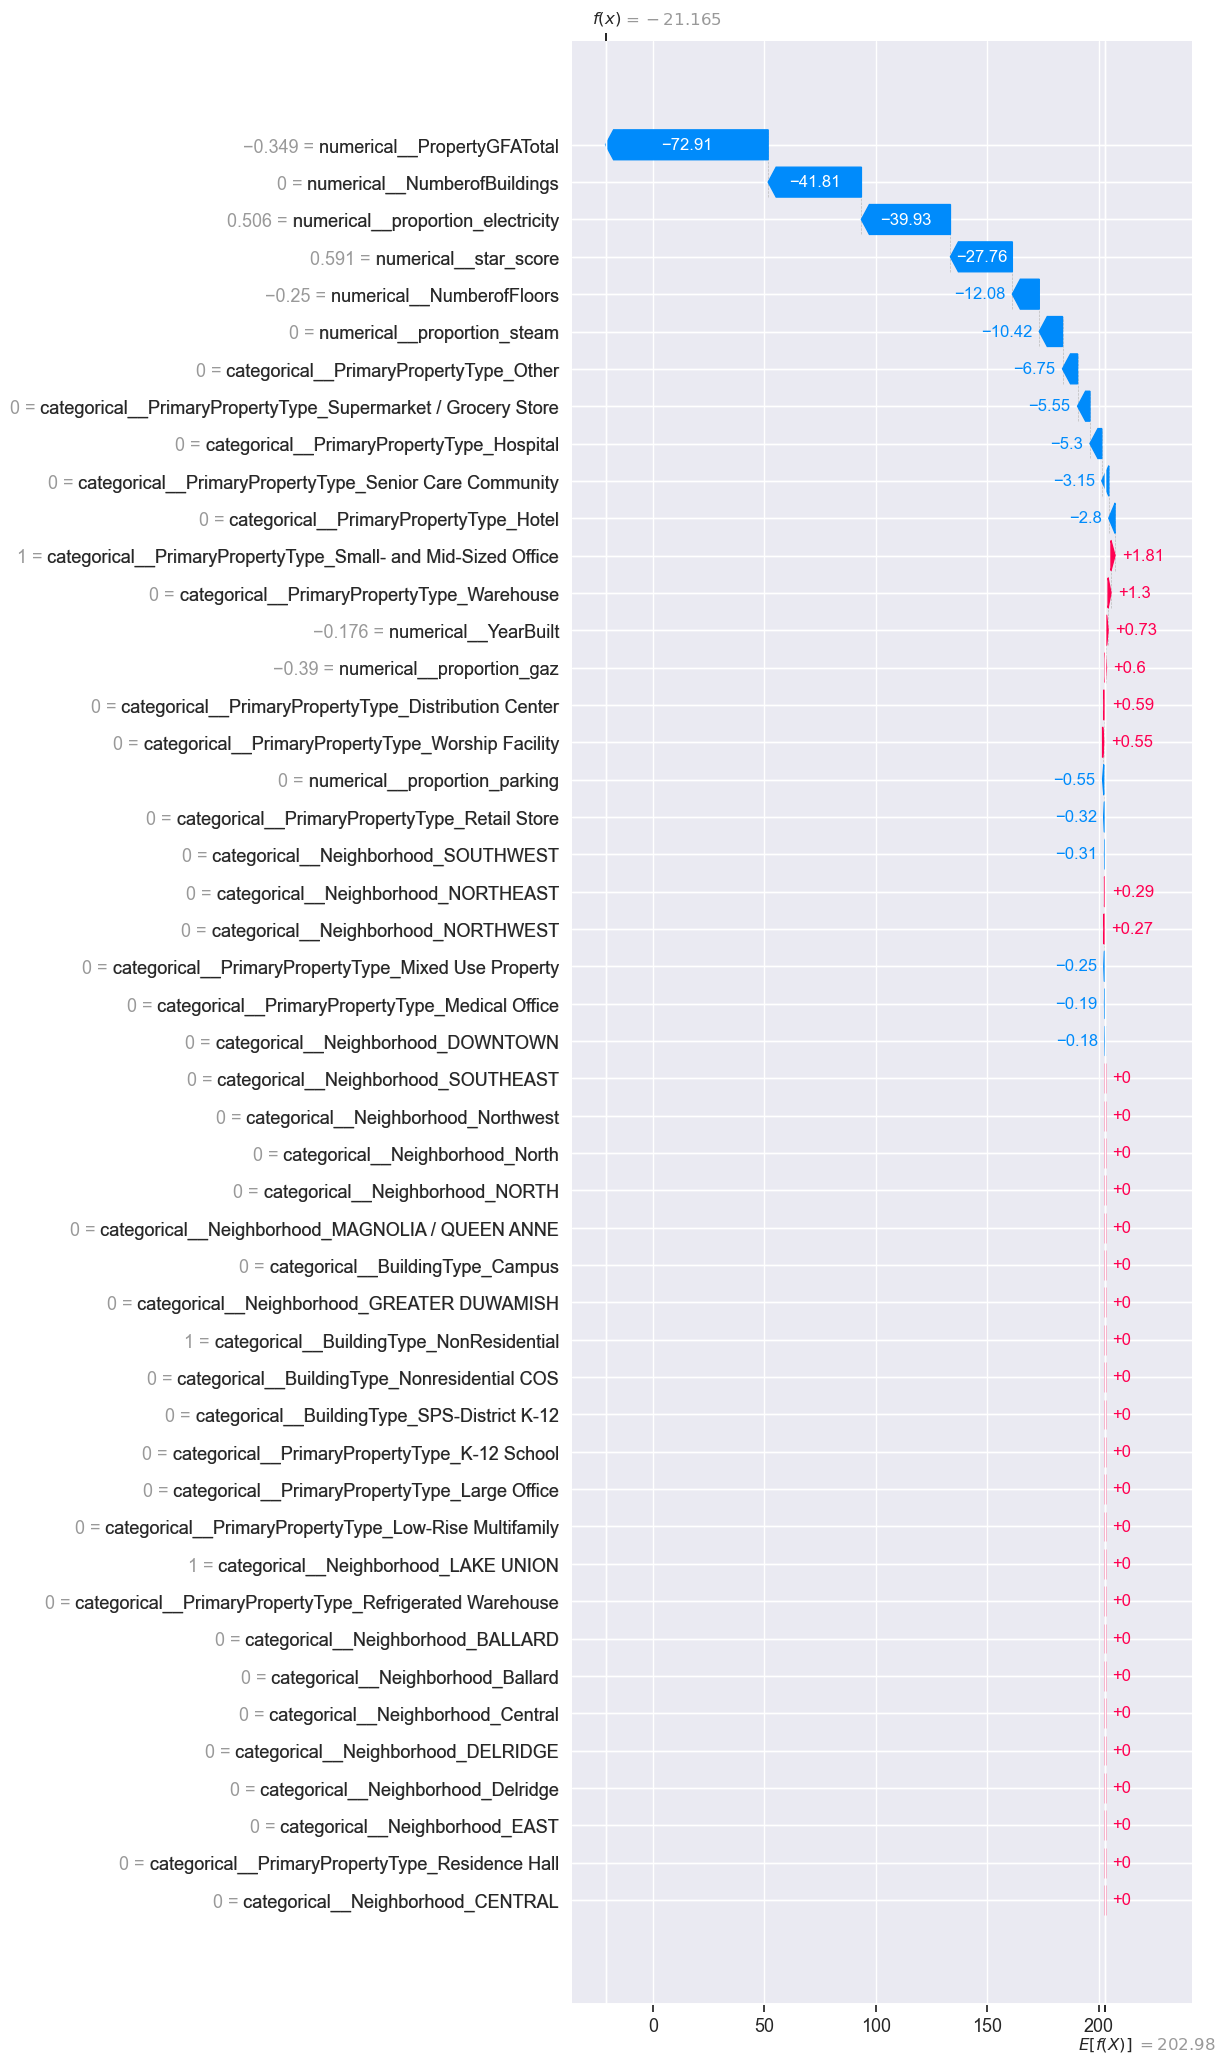

In [152]:
# Interprétation xgboost

def pipe_xgb(alea, y, graph, scaler,):
    # Séparation des jeux de données entrainement / validation, preprocessing
    X_train, X_test, y_train, y_test, preprocessor = preprocessing(y, alea=alea, test_size=test_size, \
                                                                    scaler=scaler)

    # Create a pipeline 
    pipe_tuned = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("gradient_regressor", GradientBoostingRegressor())
    ])
    
    # fit model on training set 
    time_fit = fit_and_timeit(pipe_tuned, X_train, y_train)
    # Make predictions 
    y_pred, time_predict = predict_and_timeit(pipe_tuned, X_test)    
    
    # Calculate scores on training
    r2_train, rmse_train = calcul_scores(y_train, pipe_tuned.predict(X_train))
    # and testing set
    r2_test, rmse_test = calcul_scores(y_test, y_pred)

    # Display results
    print(f"R-squared (train) =  {r2_train}")
    print(f"R-squared (test) =  {r2_test}")
    print(f"RMSE (train) =  {rmse_train}")
    print(f"RMSE (test) =  {rmse_test}" '\n')

    # display results/error as graph on first iteration (if asked to)
    if alea == 0 and graph:
        plot_predictions(r2_train, r2_test, y_pred, y_test, kind='actual_vs_predicted', y=y)
        # plot_predictions(r2_train, r2_test, y_pred, y_test, kind='residual_vs_predicted', y=y)

    # SHAP

    # Preprocess the data
    X_train_preprocessed = pipe_tuned.named_steps['preprocessor'].transform(X_train)
    X_test_preprocessed = pipe_tuned.named_steps['preprocessor'].transform(X_test)

    # Get the feature names from the preprocessor (change 'preprocessor' to the actual preprocessor name if different)
    feature_names = pipe_tuned.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)

    # If X_train_preprocessed is a sparse matrix, convert it to a dense matrix for std calculation
    X_train_preprocessed = X_train_preprocessed.toarray()
    X_test_preprocessed = X_test_preprocessed.toarray()

    # Calculate shap values
    model = pipe_tuned.named_steps["gradient_regressor"]
    explainer = shap.Explainer(model, X_train_preprocessed, feature_names=feature_names)
    shap_values = explainer(X_train_preprocessed)

    # You can visualize the summary plot to interpret the global model
    print('Interprétation globale')
    shap.summary_plot(shap_values, X_train_preprocessed, feature_names=feature_names)

    # Local : for a particular sample of data.
    print('Interprétation locale')
    shap.waterfall_plot(shap_values[0], max_display=len(feature_names))
    

pipe_xgb(42, y_G, graph=True, scaler=robust)
